Imports

In [22]:

# Sentiment Analysis
from textblob import TextBlob
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
import nltk
import pandas as pd
import re

# topic modelling
from gensim import corpora
from gensim.models import CoherenceModel, LdaModel
from gensim.corpora import Dictionary

# statistical tests
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import statsmodels.api as sm # anova
from statsmodels.formula.api import ols # regression 

# graphs
import seaborn as sns

### Data Cleaning

In [2]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r'<[^>]+>|https?:\/\/\S+', '', text) # remove HTML links
    text = re.sub(r'[^a-z\s]', '', text) # non-alphabetic characters
    tokens = word_tokenize(text)
    stop_words = set(stopwords.words('english'))

    tokens = [word for word in tokens if word not in stop_words]
    
    # spelling
    corrected_tokens = []
    for word in tokens:
        #corrected_word = str(TextBlob(word).correct())
        corrected_word = word
        corrected_tokens.append(corrected_word)
    
    stemmer = PorterStemmer()
    tokens = [stemmer.stem(word) for word in corrected_tokens]

    return ' '.join(tokens)

### Load Datasets 
(note: due to private posts they are not public)

In [3]:
f18 = pd.read_csv('fall18-c.csv')
f19 = pd.read_csv('fall19-c.csv')
f20 = pd.read_csv('fall20-c.csv')
f21 = pd.read_csv('fall21-c.csv')
f22 = pd.read_csv('fall22-c.csv')
f23 = pd.read_csv('fall23-c.csv')
dfs = [f18, f19, f20, f21, f22, f23]
years = ['2018', '2019', '2020', '2021', '2022', '2023']

for df in dfs:
    df['content'] = df['content'].astype(str).apply(clean_text)

### Calculate sentiment scores

In [4]:
nltk.download('vader_lexicon')
sia = SentimentIntensityAnalyzer()

def get_sentiment(text):
    tb_score = TextBlob(text).sentiment.polarity
    sia_score = sia.polarity_scores(text)['compound']
    return (tb_score + sia_score) / 2

for df in dfs:
    df['sentiment_score'] = df['content'].apply(get_sentiment)

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/naazsibia/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


### Segment weekly
Starting each semester from September 1st.

In [5]:
from datetime import datetime
start_dates = {
    '2018': datetime(2018, 9, 1),
    '2019': datetime(2019, 9, 1),
    '2020': datetime(2020, 9, 1),
    '2021': datetime(2021, 9, 1),
    '2022': datetime(2022, 9, 1),
    '2023': datetime(2023, 9, 1)
}

In [6]:
for year, df in zip(years, dfs):
    # Ensure 'created_at' is converted to datetime and is timezone-naive
    df['created'] = pd.to_datetime(df['created']).dt.tz_localize(None)
    
    # Calculate the course week number
    df['week'] = ((df['created'] - start_dates[year]).dt.days // 7) + 1
    
    # Filter out data that is outside the 1-12 week range
    df = df[(df['week'] >= 1) & (df['week'] <= 12)]

### Weekly Sentiment Tests

ANOVA

In [7]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

for year, df in zip(years, dfs):
    model = ols('sentiment_score ~ C(week)', data=df).fit()
    anova_table = sm.stats.anova_lm(model, typ=2)
    print(f"ANOVA for {year}:")
    print(anova_table)

ANOVA for 2018:
              sum_sq      df         F    PR(>F)
C(week)     2.575387    16.0  2.911381  0.000085
Residual  217.001724  3925.0       NaN       NaN
ANOVA for 2019:
              sum_sq      df         F        PR(>F)
C(week)     5.488474    15.0  6.922952  3.232860e-15
Residual  377.211340  7137.0       NaN           NaN
ANOVA for 2020:
              sum_sq       df         F    PR(>F)
C(week)     2.834240     13.0  3.602087  0.000011
Residual  649.863193  10737.0       NaN       NaN
ANOVA for 2021:
              sum_sq      df         F    PR(>F)
C(week)     3.894778    19.0  3.068072  0.000008
Residual  581.811006  8708.0       NaN       NaN
ANOVA for 2022:
              sum_sq      df         F    PR(>F)
C(week)     1.961007    17.0  2.154334  0.003848
Residual  383.487879  7162.0       NaN       NaN
ANOVA for 2023:
              sum_sq      df         F        PR(>F)
C(week)     3.157551    12.0  4.295445  7.846191e-07
Residual  529.573075  8645.0       NaN          

Regression

In [8]:
for year, df in zip(years, dfs):
    X = df['week']
    y = df['sentiment_score']
    X = sm.add_constant(X)  # Adds a constant term to the predictor

    model = sm.OLS(y, X).fit()
    print(f"Linear Regression Results for {year}:")
    print(model.summary())

Linear Regression Results for 2018:
                            OLS Regression Results                            
Dep. Variable:        sentiment_score   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     9.739
Date:                Thu, 07 Dec 2023   Prob (F-statistic):            0.00182
Time:                        18:47:47   Log-Likelihood:                 103.15
No. Observations:                3942   AIC:                            -202.3
Df Residuals:                    3940   BIC:                            -189.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0

Tukey HSD Tests

In [9]:
for year, df in zip(years, dfs):
    tukey = pairwise_tukeyhsd(endog=df['sentiment_score'], groups=df['week'], alpha=0.05)
    print(f"Tukey HSD Test Results for {year}:")
    print(tukey)

Tukey HSD Test Results for 2018:
Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
     2      3  -0.0316 0.9999 -0.1427  0.0796  False
     2      4   0.0233    1.0 -0.0807  0.1273  False
     2      5   0.0088    1.0 -0.1202  0.1378  False
     2      6   0.0226    1.0 -0.0754  0.1206  False
     2      7  -0.0016    1.0 -0.0968  0.0935  False
     2      8  -0.0196    1.0 -0.1412   0.102  False
     2      9  -0.0167    1.0 -0.1239  0.0906  False
     2     10  -0.0431 0.9846 -0.1407  0.0544  False
     2     11  -0.0385 0.9919 -0.1312  0.0542  False
     2     12  -0.0233    1.0 -0.1235  0.0769  False
     2     13   -0.008    1.0 -0.1074  0.0914  False
     2     14  -0.0331 0.9985 -0.1255  0.0594  False
     2     15  -0.0004    1.0 -0.0975  0.0967  False
     2     16   -0.054 0.9699 -0.1681    0.06  False
     2     17  -0.2975 0.1025 -0.6169   0.022  False
     2     18

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/integrate/quadpack.py:879: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Tukey HSD Test Results for 2019:
Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
     2      3  -0.1109 0.1601 -0.2368  0.0149  False
     2      4   -0.079 0.7882 -0.2101  0.0522  False
     2      5  -0.0891 0.4777 -0.2115  0.0334  False
     2      6  -0.1209 0.0551 -0.2429  0.0011  False
     2      7  -0.1122 0.2454 -0.2475  0.0231  False
     2      8  -0.1504 0.0054 -0.2779 -0.0229   True
     2      9  -0.1402 0.0162 -0.2681 -0.0123   True
     2     10  -0.1239 0.0508  -0.248  0.0002  False
     2     11  -0.1347  0.016 -0.2575 -0.0119   True
     2     12  -0.0908 0.4924 -0.2167  0.0351  False
     2     13  -0.1215 0.0554 -0.2442  0.0012  False
     2     14  -0.1624 0.0004  -0.283 -0.0419   True
     2     15  -0.0777 0.8349  -0.212  0.0566  False
     2     16  -0.1261 0.0391 -0.2496 -0.0027   True
     2     17  -0.0063    1.0 -0.2363  0.2238  False
     3      4

Visualize Weekly Changes

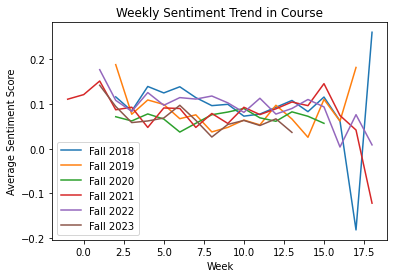

In [11]:
import matplotlib.pyplot as plt

dfs2 = [f18, f19, f20, f21, f22, f23]
years = ['2018', '2019', '2020', '2021', '2022', '2023']
for i, df in enumerate(dfs2):
    weekly_sentiment = df.groupby('week')['sentiment_score'].mean()
    plt.plot(weekly_sentiment, label=f'Fall {years[i]}')

plt.xlabel('Week')
plt.ylabel('Average Sentiment Score')
plt.title('Weekly Sentiment Trend in Course')
plt.legend()
plt.show()

### Topic Analysis for a week

In [15]:
week_8_posts = f19[f19['week'] == 8]['content'].tolist()

documents_week8 = [post.split() for post in week_8_posts]

dictionary = Dictionary(documents_week8)
corpus = [dictionary.doc2bow(doc) for doc in documents_week8]

coherence_scores = {}
for num_topics in range(2, 12):
    lda_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics)
    coherence_model = CoherenceModel(model=lda_model, texts=documents_week8, dictionary=dictionary, coherence='c_v')
    coherence_scores[num_topics] = coherence_model.get_coherence()

optimal_num_topics = max(coherence_scores, key=coherence_scores.get)
print(f"Optimal Number of Topics: {optimal_num_topics}")

optimal_lda_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=optimal_num_topics)

for idx, topic in optimal_lda_model.print_topics(-1):
    print(f"Topic: {idx} \nWords: {topic}")

    words = topic.split("+")
    topic_sentiment = 0

    for word in words:
        word = word.split("*")[1].replace('"', '').strip()  # Extract the word
        sentiment = TextBlob(word).sentiment.polarity  # Get sentiment score
        topic_sentiment += sentiment

    avg_sentiment = topic_sentiment / len(words)
    print(f"Average Sentiment for Topic {idx}: {avg_sentiment}\n")


Optimal Number of Topics: 6
Topic: 0 
Words: 0.016*"week" + 0.012*"valu" + 0.012*"read" + 0.011*"return" + 0.010*"midterm" + 0.009*"go" + 0.009*"loop" + 0.009*"mean" + 0.009*"post" + 0.009*"use"
Average Sentiment for Topic 0: -0.03125

Topic: 1 
Words: 0.014*"question" + 0.011*"run" + 0.011*"code" + 0.010*"would" + 0.009*"first" + 0.009*"list" + 0.009*"valu" + 0.009*"x" + 0.009*"discount" + 0.009*"return"
Average Sentiment for Topic 1: 0.025

Topic: 2 
Words: 0.017*"still" + 0.017*"tweet" + 0.013*"pcr" + 0.011*"work" + 0.010*"symbol" + 0.010*"error" + 0.009*"tri" + 0.009*"b" + 0.009*"servic" + 0.009*"show"
Average Sentiment for Topic 2: 0.0

Topic: 3 
Words: 0.020*"list" + 0.017*"function" + 0.016*"x" + 0.015*"use" + 0.013*"need" + 0.011*"code" + 0.009*"loop" + 0.008*"mean" + 0.008*"get" + 0.008*"object"
Average Sentiment for Topic 3: -0.03125

Topic: 4 
Words: 0.016*"use" + 0.014*"nan" + 0.012*"return" + 0.011*"valu" + 0.009*"loop" + 0.009*"could" + 0.007*"list" + 0.007*"load" + 0.007

### Yearly Analysis

ANOVA

In [16]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

# Concatenate your DataFrames into one, with a 'year' column to identify each
all_data = pd.concat(dfs, keys=['2018', '2019', '2020', '2021', '2022', '2023']).reset_index(level=0).rename(columns={'level_0': 'year'})

# Fit the ANOVA model
model = ols('sentiment_score ~ C(year)', data=all_data).fit()

# Perform ANOVA
anova_results = sm.stats.anova_lm(model, typ=2)
print(anova_results)

               sum_sq       df         F        PR(>F)
C(year)      9.971123      5.0  33.54429  2.585460e-34
Residual  2758.859654  46406.0       NaN           NaN


Tukey HSD

In [18]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Perform Tukey's HSD test for multiple comparisons
tukey_results = pairwise_tukeyhsd(endog=all_data['sentiment_score'], groups=all_data['year'], alpha=0.05)

# Print the results
print(tukey_results)

# If you want to see the results in a table format, which might be easier to interpret, you can do:
tukey_results_df = pd.DataFrame(data=tukey_results._results_table.data[1:], columns=tukey_results._results_table.data[0])
print(tukey_results_df)

Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
  2018   2019  -0.0352    0.0  -0.049 -0.0214   True
  2018   2020  -0.0307    0.0 -0.0436 -0.0177   True
  2018   2021  -0.0135 0.0444 -0.0269 -0.0002   True
  2018   2022   0.0003    1.0 -0.0134  0.0141  False
  2018   2023  -0.0364    0.0 -0.0498 -0.0231   True
  2019   2020   0.0046  0.824  -0.006  0.0152  False
  2019   2021   0.0217    0.0  0.0106  0.0328   True
  2019   2022   0.0356    0.0   0.024  0.0472   True
  2019   2023  -0.0012 0.9997 -0.0123  0.0099  False
  2020   2021   0.0171    0.0  0.0071  0.0271   True
  2020   2022    0.031    0.0  0.0204  0.0416   True
  2020   2023  -0.0057 0.5787 -0.0158  0.0043  False
  2021   2022   0.0139 0.0048  0.0028  0.0249   True
  2021   2023  -0.0229    0.0 -0.0334 -0.0123   True
  2022   2023  -0.0367    0.0 -0.0478 -0.0257   True
----------------------------------------------

Topics for each year with sentiment scores

In [20]:
yearly_lda_results = {}

for year, df in zip(['2018', '2019', '2020', '2021', '2022', '2023'], dfs):
    documents = [post.split() for post in df['content'].tolist()]

    dictionary = Dictionary(documents)
    corpus = [dictionary.doc2bow(doc) for doc in documents]

    coherence_scores = {}
    for num_topics in range(2, 12):
        lda_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics)
        coherence_model = CoherenceModel(model=lda_model, texts=documents, dictionary=dictionary, coherence='c_v')
        coherence_scores[num_topics] = coherence_model.get_coherence()

    optimal_num_topics = max(coherence_scores, key=coherence_scores.get)

    # LDA with optimal topic number
    optimal_lda_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=optimal_num_topics)

    yearly_topics = {}
    for idx, topic in optimal_lda_model.show_topics(num_topics=optimal_num_topics, formatted=False):
        topic_words = [word for word, _ in topic]
        topic_sentiment = sum(TextBlob(word).sentiment.polarity for word in topic_words) / len(topic_words)
        yearly_topics[idx] = {"Words": topic_words, "Average Sentiment": topic_sentiment}

    yearly_lda_results[year] = yearly_topics

for year, topics in yearly_lda_results.items():
    print(f"Year: {year}")
    for topic, data in topics.items():
        print(f"Topic {topic}:")
        print(f"Words: {', '.join(data['Words'])}")
        print(f"Average Sentiment: {data['Average Sentiment']}\n")
    print("\n")

Year: 2018
Topic 0:
Words: function, use, list, assign, test, return, code, case, exampl, true
Average Sentiment: 0.034999999999999996

Topic 1:
Words: function, return, use, code, valu, would, test, file, dont, make
Average Sentiment: 0.0



Year: 2019
Topic 0:
Words: function, file, code, test, error, line, use, exampl, assign, docstr
Average Sentiment: 0.0

Topic 1:
Words: function, return, use, tweet, code, one, like, would, string, true
Average Sentiment: 0.034999999999999996



Year: 2020
Topic 0:
Words: question, thank, return, code, function, dont, work, use, true, tri
Average Sentiment: 0.034999999999999996

Topic 1:
Words: error, return, function, use, code, line, get, test, tri, file
Average Sentiment: 0.0



Year: 2021
Topic 0:
Words: use, code, question, function, like, tri, get, thank, need, lab
Average Sentiment: 0.0

Topic 1:
Words: line, string, use, valu, loop, return, code, list, x, variabl
Average Sentiment: 0.0

Topic 2:
Words: answer, post, question, test, return,

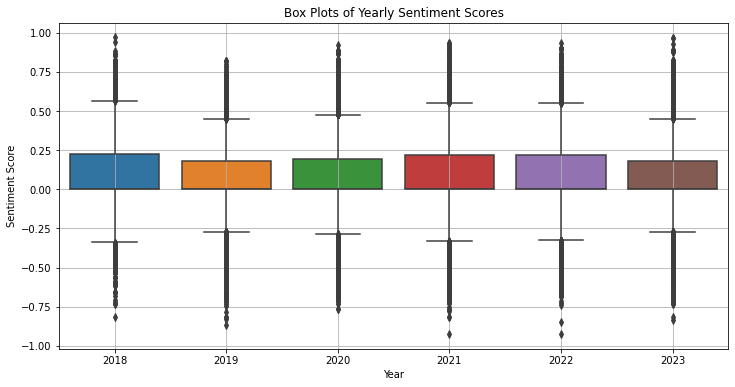

In [23]:

# Plotting the box plot
plt.figure(figsize=(12, 6))
sns.boxplot(x='year', y='sentiment_score', data=all_data)
plt.title('Box Plots of Yearly Sentiment Scores')
plt.xlabel('Year')
plt.ylabel('Sentiment Score')
plt.grid(True)
plt.show()

### Appendix

Checking how anonymity relates to sentiment

In [24]:
import statsmodels.api as sm
for df in dfs:
    # Assuming 'df' is your DataFrame and it contains a binary 'anonymity' column where anonymous = 1 and public = 0
    df['anonymity2'] = df['anonymity'].map(lambda x: 1 if x == 'stud' else 0)

    # Define the dependent variable
    y = df['sentiment_score']

    # Define the independent variables
    X = df[['anonymity2']]  # Add other control variables if you have any
    X = sm.add_constant(X)  # Adds a constant term to the predictor

    # Fit the OLS model
    model = sm.OLS(y, X).fit()

    # Print the summary
    print(model.summary())

                            OLS Regression Results                            
Dep. Variable:        sentiment_score   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.854
Date:                Fri, 08 Dec 2023   Prob (F-statistic):              0.173
Time:                        00:45:53   Log-Likelihood:                 99.207
No. Observations:                3942   AIC:                            -194.4
Df Residuals:                    3940   BIC:                            -181.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1022      0.005     21.661      0.0